In [1]:
pip install keras-resnet

  Preparing metadata (setup.py) ... done
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20486 sha256=98ddfb8de1efa425507eef2e33c7d992b8bc87f8172459a9c5872205c792e0a8
  Stored in directory: /aiffel/.cache/pip/wheels/53/ed/ef/144804f160c278c80d6429c97ed126b61276721894ce64cccc
Successfully built keras-resnet
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import matplotlib.pyplot as plt
from keras_resnet.models import ResNet18

In [4]:
# 데이터 경로 설정
dataset_path = "../_preprocessed_datasets_del_aug_duplicate"
categories = ["blue_jellyfish", "barrel_jellyfish", "compass_jellyfish", 
              "lions_mane_jellyfish", "mauve_stinger_jellyfish", "Moon_jellyfish"]
# 하이퍼파라미터 설정
img_height, img_width = 224, 224
batch_size = 32
epochs = 40
learning_rate = 0.001

In [5]:
# 데이터 준비 함수
def prepare_data(dataset_path, categories):
    filepaths, labels = [], []
    for label, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        if os.path.exists(category_path):
            for file in os.listdir(category_path):
                if file.endswith(('jpg', 'jpeg', 'png')):
                    filepaths.append(os.path.join(category_path, file))
                    labels.append(category)
    return filepaths, labels

filepaths, labels = prepare_data(dataset_path, categories)

In [6]:
# DataFrame 생성
data = pd.DataFrame({'filename': filepaths, 'class': labels})

In [7]:
# Train/Test 분리
train_df, test_df = train_test_split(data, test_size=0.2, stratify=data['class'], random_state=42)

# Train/Validation 분리
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['class'], random_state=42)

In [8]:
# ImageDataGenerator 사용
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='class',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 960 validated image filenames belonging to 6 classes.
Found 240 validated image filenames belonging to 6 classes.
Found 300 validated image filenames belonging to 6 classes.


In [9]:
# ResNet18 모델 생성
num_classes = len(categories)

# 입력 텐서 정의
inputs = tf.keras.Input(shape=(img_height, img_width, 3))

In [15]:
# ResNet18 모델 불러오기
resnet18 = ResNet18(inputs, classes=num_classes)

# 모델 컴파일
resnet18.compile(optimizer=Adam(learning_rate=learning_rate),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

In [16]:
# 모델 훈련
history = resnet18.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

# 테스트 평가
test_loss, test_acc = resnet18.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Epoch 1/40
30/30 [==============================] - 13s 369ms/step - loss: 2.1395 - accuracy: 0.3385 - val_loss: 391.2451 - val_accuracy: 0.1667
Epoch 2/40
30/30 [==============================] - 11s 359ms/step - loss: 1.4148 - accuracy: 0.4510 - val_loss: 14.3567 - val_accuracy: 0.1667
Epoch 3/40
30/30 [==============================] - 11s 357ms/step - loss: 1.2322 - accuracy: 0.5198 - val_loss: 2.4418 - val_accuracy: 0.2708
Epoch 4/40
30/30 [==============================] - 11s 355ms/step - loss: 1.1497 - accuracy: 0.5615 - val_loss: 2.6523 - val_accuracy: 0.2500
Epoch 5/40
30/30 [==============================] - 11s 358ms/step - loss: 1.0724 - accuracy: 0.6010 - val_loss: 2.9771 - val_accuracy: 0.2208
Epoch 6/40
30/30 [==============================] - 11s 355ms/step - loss: 0.9821 - accuracy: 0.6135 - val_loss: 2.6478 - val_accuracy: 0.2708
Epoch 7/40
30/30 [==============================] - 11s 355ms/step - loss: 1.0253 - accuracy: 0.6083 - val_loss: 4.5395 - val_accuracy: 0.2

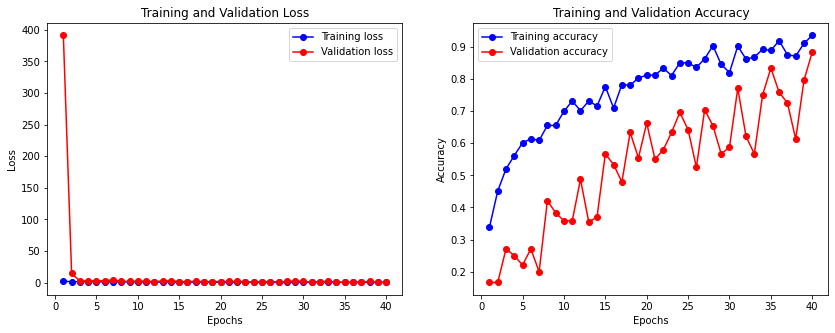

In [17]:
# 훈련 이력 시각화
def plot_training_history(history):
    epochs_range = range(1, len(history.history['loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Loss 그래프
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['loss'], 'bo-', label='Training loss')
    plt.plot(epochs_range, history.history['val_loss'], 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['accuracy'], 'bo-', label='Training accuracy')
    plt.plot(epochs_range, history.history['val_accuracy'], 'ro-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_training_history(history)

In [18]:
# 테스트 데이터에서 5개의 이미지를 가져옵니다.
import numpy as np

# 클래스 인덱스를 클래스 이름으로 매핑합니다.
class_indices = test_generator.class_indices
indices_to_class = dict((v, k) for k, v in class_indices.items())

# 테스트 제너레이터에서 한 배치의 데이터를 가져옵니다.
test_images, test_labels = test_generator.next()

In [19]:
# 5개의 이미지와 라벨을 선택합니다.
num_display = 5
images = test_images[:num_display]
labels = test_labels[:num_display]

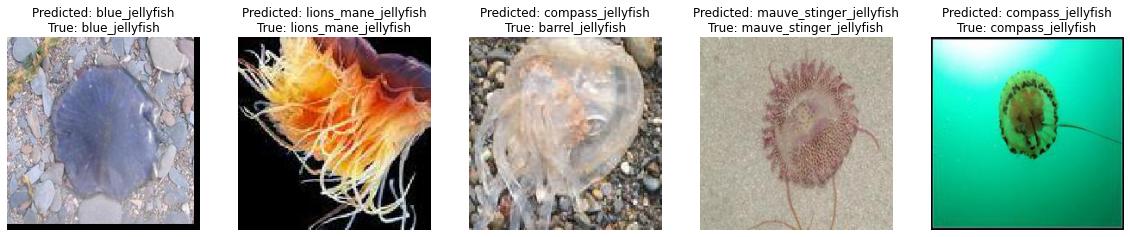

In [20]:
# 모델을 사용하여 예측합니다.
predictions = resnet18.predict(images)
predicted_class_indices = np.argmax(predictions, axis=1)
predicted_class_labels = [indices_to_class[idx] for idx in predicted_class_indices]

# 실제 라벨도 가져옵니다.
true_class_indices = np.argmax(labels, axis=1)
true_class_labels = [indices_to_class[idx] for idx in true_class_indices]

# 이미지를 출력합니다.
plt.figure(figsize=(20, 10))
for i in range(num_display):
    plt.subplot(1, num_display, i+1)
    plt.imshow(images[i])
    plt.title(f"Predicted: {predicted_class_labels[i]}\nTrue: {true_class_labels[i]}")
    plt.axis('off')
plt.show()